In [27]:
import numpy as np
import copy
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science', 'grid', 'no-latex'])
# plt.style.use(['science', 'grid'])
import Direct_Strapdown as ds
import Kalman_vol3_ubuntu as Kalman
import RTS as RTS
params = {'axes.labelsize': 'xx-large', 'axes.titlesize':'xx-large','xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 'legend.fontsize': 'xx-large','mathtext.fontset':'stix', 'font.family':'STIXGeneral'}
plt.rcParams.update(params)
from tqdm import tqdm
import pandas as pd
import os
import warnings
from PIL import Image
from pathlib import Path
import pickle
# To ignore all warnings
warnings.filterwarnings("ignore")
from scipy.interpolate import interp1d

In [28]:
file_path = "../Results/DS_300Hz_150s_3_stages.pkl"

print(f"Loading DS results from: {file_path}")
with open(file_path, 'rb') as file: 
    DS = pickle.load(file)
DS["vel_scalar"] = ds.vel_scalar(DS["vn"], DS["ve"], DS["vd"])


Loading DS results from: ../Results/DS_300Hz_150s_3_stages.pkl


In [29]:

min = 9700
max = 20200

Ref = {}                                        # Determined using visual inspection
Ref["all_lines"] = np.arange(min,max+1)
Ref["Line_1"] = np.arange(min+350,min+1950+1)
Ref["Line_2"] = np.arange(min+2250,min+4200+1)
Ref["Line_3"] = np.arange(min+4490,min+6050+1)
Ref["Line_4"] = np.arange(min+6400,min+8300+1)
Ref["Line_5"] = np.arange(min+8650,max-250+1)

Line = ["Line_1", "Line_2", "Line_3", "Line_4", "Line_5"]

Ref["all"] = np.concatenate(np.array([Ref["Line_1"], Ref["Line_2"], Ref["Line_3"], Ref["Line_4"], Ref["Line_5"]]))
delta_id = Ref["all"][::120]        # Take out every 120'th id for delta implementation

In [109]:
min_val = 0
max_val = 10

Ref = {}
Ref["Line_1"] = np.arange(min_val + 350, min_val + 1950 + 1)
Ref["Line_2"] = np.arange(min_val + 2250, min_val + 4200 + 1)
Ref["Line_3"] = np.arange(min_val + 4490, min_val + 6050 + 1)
Ref["Line_4"] = np.arange(min_val + 6400, min_val + 8300 + 1)
Ref["Line_5"] = np.arange(min_val + 8650, max_val - 250 + 1)

Line = ["Line_1", "Line_2", "Line_3", "Line_4", "Line_5"]

# Concatenate arrays vertically
Ref["all"] = np.hstack([Ref[line] for line in Line])

print(Ref["all"])

[ 350  351  352 ... 8298 8299 8300]


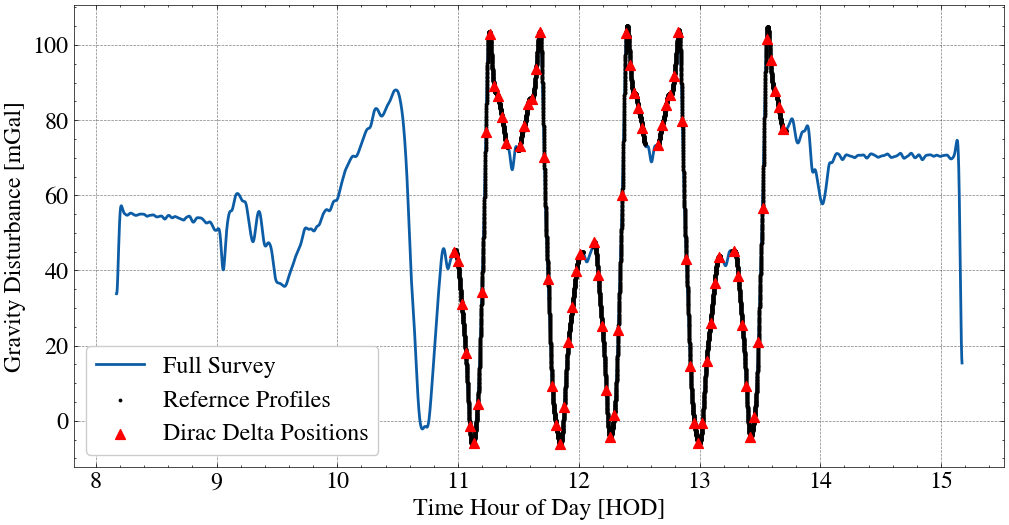

In [30]:
plt.figure(figsize=(12,6))
plt.plot(ds.SOW2HOD(DS["time"]), DS["fdg"][:,2], lw=2, label="Full Survey")
# for i in range(len(Line)): 
#     plt.plot(DS["time"][Ref[Line[i]]], DS["fdg"][Ref[Line[i]],2], lw=2, label=f"Profile {i+1}")
plt.scatter(ds.SOW2HOD(DS["time"])[Ref["all"]], DS["fdg"][Ref["all"],2], s=3, color="black", zorder=10, label="Refernce Profiles")
plt.scatter(ds.SOW2HOD(DS["time"])[delta_id], DS["fdg"][delta_id,2], s=50, color="red", zorder=10, marker='^', label="Dirac Delta Positions")
plt.xlabel("Time Hour of Day [HOD]")
plt.ylabel("Gravity Disturbance [mGal]")
plt.legend()
plt.show()

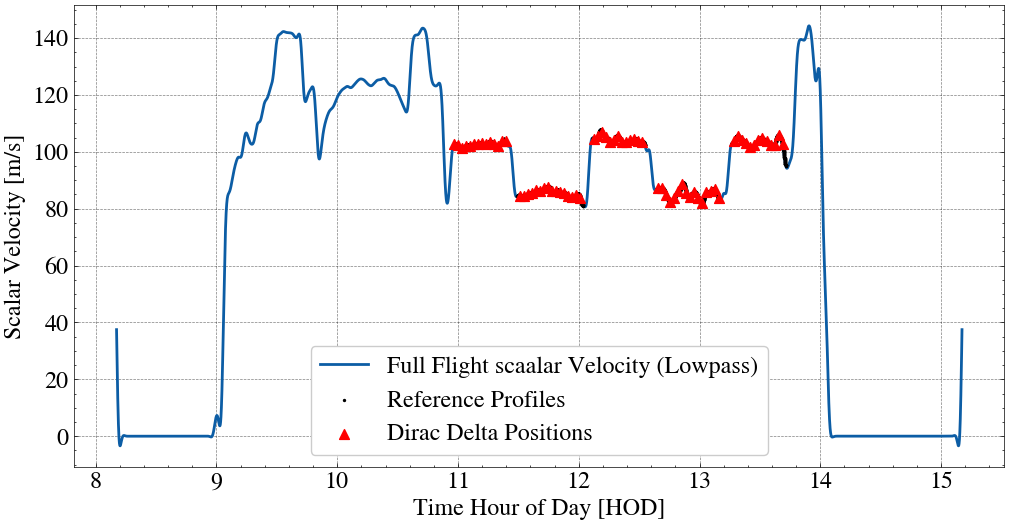

In [37]:
vel = ds.but2_v2(DS["vel_scalar"], 3, 150, 1)

plt.figure(figsize=(12,6))
plt.plot(ds.SOW2HOD(DS["time"]), vel, lw=2, label="Full Flight scaalar Velocity (Lowpass)")
plt.scatter(ds.SOW2HOD(DS["time"])[Ref["all"]], vel[Ref["all"]], s=2, label="Reference Profiles", color="black", zorder=10)
plt.scatter(ds.SOW2HOD(DS["time"])[delta_id], vel[delta_id], s=50, color="red", zorder=10, marker='^', label="Dirac Delta Positions")
plt.xlabel("Time Hour of Day [HOD]")
plt.ylabel("Scalar Velocity [m/s]")
plt.legend()
plt.show()

In [57]:
def Calc_Spatial_res(delta_id, vel):
    file_path = "../Results/DS_300Hz_150s_3_stages.pkl"
    Spatial_res = np.array([])
    for dirac in tqdm(delta_id, colour="green"):
        with open(file_path, 'rb') as file: 
            DS = pickle.load(file)
        # Run normal Kalman Lowpass
        kf_orig, rts = Kalman.KalmanFilterLowpass(DS, 2)
        rts_orig = RTS.RTS_smoother(rts)

        # Plot Ref line to check result: 
        # Kalman.plot_ref_line(rts_orig, DS)

        # Ad a dirac delta function to raw signal: 
        deltafunc = np.zeros(len(DS["time"]))
        deltafunc[dirac] = 1
        DS["dg"][:,2] = DS["dg"][:,2] + deltafunc

        # Run second iteration Kalman + RTS with Delta function implemented. 
        kf_new, rts = Kalman.KalmanFilterLowpass(DS, 2)
        rts_new = RTS.RTS_smoother(rts)

        diff = rts_new["profile"][:,0] - rts_orig["profile"][:,0]

        # Cut out AOI 
        delta_cut = 1000
        deltafunc = deltafunc[dirac-delta_cut:dirac+delta_cut]
        diff = diff[dirac-delta_cut:dirac+delta_cut]

        # Compute the FFT of the input signal (Dirac delta function)
        fft_input = np.fft.fft(deltafunc)

        # Compute the FFT of the output signal (filtered signal)
        fft_output = np.fft.fft(diff)

        # Compute the frequency response
        H_fft = fft_output / fft_input

        # Extract the magnitude and phase of the frequency response
        magnitude = np.abs(H_fft)
        phase = np.angle(H_fft)

        # Generate frequency vector
        sampling_freq = 1  # Assuming unit sampling frequency
        freq_vector = np.fft.fftfreq(len(DS["time"][dirac-delta_cut:dirac+delta_cut]), d=1/sampling_freq)

        # Interpolate absolute values of H_fft
        interp_func = interp1d(freq_vector, magnitude, kind='linear')

        # Find frequency corresponding to half maximum
        half_max = np.max(magnitude) / 2
        # Increase the number of points for evaluation
        freq_vector_interp = np.linspace(freq_vector.min(), freq_vector.max(), num=len(freq_vector)*100)

        # Find frequency corresponding to half maximum using the interpolated function with more points
        half_max_frequency = abs(freq_vector_interp[np.argmin(np.abs(interp_func(freq_vector_interp) - half_max))])

        # Calculate FWHM 
        fwhm = 1/(2*half_max_frequency)

        # Calculate FWHM Spatial Resolution in [km]
        Spatial_res_ = (vel[dirac] * fwhm)/1000

        Spatial_res = np.append(Spatial_res, Spatial_res_)
    return Spatial_res
Spatial_res = Calc_Spatial_res(delta_id, vel)


  0%|          | 0/72 [00:00<?, ?it/s]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.57 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

  1%|▏         | 1/72 [00:08<09:54,  8.37s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.67 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.68 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

  3%|▎         | 2/72 [00:16<09:50,  8.44s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.61 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.97 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

  4%|▍         | 3/72 [00:27<10:44,  9.35s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.22 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

  6%|▌         | 4/72 [00:38<11:15,  9.93s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.03 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.04 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

  7%|▋         | 5/72 [00:48<11:25, 10.23s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.17 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.08 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

  8%|▊         | 6/72 [01:00<11:43, 10.66s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 3.32 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

 10%|▉         | 7/72 [01:13<12:20, 11.39s/it]

100%  [ .................... ] done
Time elapsed: 2.36 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.53 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 11%|█         | 8/72 [01:26<12:41, 11.90s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.49 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.38 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 12%|█▎        | 9/72 [01:39<12:52, 12.26s/it]

100%  [ .................... ] done
Time elapsed: 2.44 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.07 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 14%|█▍        | 10/72 [01:50<12:21, 11.95s/it]

100%  [ .................... ] done
Time elapsed: 2.23 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.33 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 15%|█▌        | 11/72 [02:02<12:09, 11.96s/it]

100%  [ .................... ] done
Time elapsed: 2.10 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.14 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 17%|█▋        | 12/72 [02:13<11:35, 11.59s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.92 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

 18%|█▊        | 13/72 [02:23<10:57, 11.14s/it]

100%  [ .................... ] done
Time elapsed: 1.94 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.99 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 19%|█▉        | 14/72 [02:33<10:27, 10.82s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.93 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.91 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 21%|██        | 15/72 [02:43<10:03, 10.59s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.95 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.96 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

 22%|██▏       | 16/72 [02:53<09:43, 10.42s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.93 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.00 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 24%|██▎       | 17/72 [03:03<09:29, 10.36s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.95 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.94 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

 25%|██▌       | 18/72 [03:13<09:14, 10.27s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.92 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.99 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

 26%|██▋       | 19/72 [03:23<08:59, 10.19s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.69 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.96 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

 28%|██▊       | 20/72 [03:33<08:47, 10.14s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.96 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

 29%|██▉       | 21/72 [03:44<08:41, 10.23s/it]

100%  [ .................... ] done
Time elapsed: 1.96 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.95 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 31%|███       | 22/72 [03:54<08:32, 10.25s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.90 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.94 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

 32%|███▏      | 23/72 [04:04<08:21, 10.23s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.97 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

 33%|███▎      | 24/72 [04:15<08:12, 10.25s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.94 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

 35%|███▍      | 25/72 [04:25<08:02, 10.26s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.00 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.97 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 36%|███▌      | 26/72 [04:35<07:50, 10.23s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.90 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.94 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

 38%|███▊      | 27/72 [04:45<07:40, 10.24s/it]

100%  [ .................... ] done
Time elapsed: 1.95 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.96 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 39%|███▉      | 28/72 [04:56<07:32, 10.28s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.04 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.99 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 40%|████      | 29/72 [05:06<07:21, 10.26s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.95 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.96 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

 42%|████▏     | 30/72 [05:16<07:10, 10.24s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.01 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.95 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 43%|████▎     | 31/72 [05:26<06:58, 10.21s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.03 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

 44%|████▍     | 32/72 [05:36<06:49, 10.24s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.95 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

 46%|████▌     | 33/72 [05:47<06:38, 10.21s/it]

100%  [ .................... ] done
Time elapsed: 1.93 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.94 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 47%|████▋     | 34/72 [05:57<06:26, 10.18s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.92 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.92 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

 49%|████▊     | 35/72 [06:07<06:15, 10.15s/it]

100%  [ .................... ] done
Time elapsed: 1.93 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.92 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 50%|█████     | 36/72 [06:17<06:06, 10.17s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.94 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.90 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

 51%|█████▏    | 37/72 [06:27<05:54, 10.12s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.93 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

 53%|█████▎    | 38/72 [06:37<05:40, 10.02s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.81 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.72 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

 54%|█████▍    | 39/72 [06:47<05:28,  9.97s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.00 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.03 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 56%|█████▌    | 40/72 [06:57<05:26, 10.21s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.04 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.09 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 57%|█████▋    | 41/72 [07:09<05:30, 10.65s/it]

100%  [ .................... ] done
Time elapsed: 2.39 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.37 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 58%|█████▊    | 42/72 [07:21<05:34, 11.15s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.25 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.22 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 60%|█████▉    | 43/72 [07:33<05:30, 11.39s/it]

100%  [ .................... ] done
Time elapsed: 2.31 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.19 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 61%|██████    | 44/72 [07:46<05:25, 11.62s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.42 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.25 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 62%|██████▎   | 45/72 [07:57<05:15, 11.68s/it]

100%  [ .................... ] done
Time elapsed: 2.30 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.26 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 64%|██████▍   | 46/72 [08:10<05:08, 11.88s/it]

100%  [ .................... ] done
Time elapsed: 2.29 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.48 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 65%|██████▌   | 47/72 [08:24<05:15, 12.63s/it]

100%  [ .................... ] done
Time elapsed: 2.74 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.49 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 67%|██████▋   | 48/72 [08:38<05:09, 12.90s/it]

100%  [ .................... ] done
Time elapsed: 2.79 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.82 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 68%|██████▊   | 49/72 [08:52<05:06, 13.31s/it]

100%  [ .................... ] done
Time elapsed: 2.23 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.64 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 69%|██████▉   | 50/72 [09:05<04:50, 13.21s/it]

100%  [ .................... ] done
Time elapsed: 2.53 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.65 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 71%|███████   | 51/72 [09:18<04:38, 13.25s/it]

90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.46 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.31 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    

 72%|███████▏  | 52/72 [09:30<04:18, 12.94s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.23 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.25 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 74%|███████▎  | 53/72 [09:42<03:59, 12.59s/it]

100%  [ .................... ] done
Time elapsed: 2.22 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.21 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 75%|███████▌  | 54/72 [09:54<03:41, 12.30s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.27 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

 76%|███████▋  | 55/72 [10:06<03:28, 12.24s/it]

100%  [ .................... ] done
Time elapsed: 2.25 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.42 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 78%|███████▊  | 56/72 [10:18<03:14, 12.18s/it]

100%  [ .................... ] done
Time elapsed: 2.28 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.82 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 79%|███████▉  | 57/72 [10:30<03:03, 12.24s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.93 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.19 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 81%|████████  | 58/72 [10:42<02:48, 12.04s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.22 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.15 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 82%|████████▏ | 59/72 [10:53<02:33, 11.78s/it]

100%  [ .................... ] done
Time elapsed: 2.16 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.25 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 83%|████████▎ | 60/72 [11:05<02:20, 11.70s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.26 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.29 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 85%|████████▍ | 61/72 [11:17<02:10, 11.85s/it]

100%  [ .................... ] done
Time elapsed: 2.34 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.26 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 86%|████████▌ | 62/72 [11:28<01:57, 11.75s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.93 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.37 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 88%|████████▊ | 63/72 [11:40<01:46, 11.82s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.17 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.23 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 89%|████████▉ | 64/72 [11:52<01:35, 11.89s/it]

100%  [ .................... ] done
Time elapsed: 2.30 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.25 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 90%|█████████ | 65/72 [12:04<01:22, 11.77s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.98 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.14 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 92%|█████████▏| 66/72 [12:16<01:10, 11.75s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.47 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.90 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 93%|█████████▎| 67/72 [12:27<00:57, 11.51s/it]

95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.17 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.14 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    

 94%|█████████▍| 68/72 [12:38<00:45, 11.42s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.13 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

 96%|█████████▌| 69/72 [12:49<00:33, 11.30s/it]

100%  [ .................... ] done
Time elapsed: 1.95 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.92 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    

 97%|█████████▋| 70/72 [12:59<00:21, 10.96s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 1.91 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

 99%|█████████▊| 71/72 [13:09<00:10, 10.74s/it]

RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ..........          55%    [ ...........         60%    [ ............        65%    [ .............       70%    [ ..............      75%    [ ...............     80%    [ ................    85%    [ .................   90%    [ ..................  95%    [ ................... 100%  [ .................... ] done
Time elapsed: 2.07 seconds
RTS smoother (25204 epochs):
0%    [                     5%    [ .                   10%    [ ..                  15%    [ ...                 20%    [ ....                25%    [ .....               30%    [ ......              35%    [ .......             40%    [ ........            45%    [ .........           50%    [ ....

100%|██████████| 72/72 [13:19<00:00, 11.11s/it]

100%  [ .................... ] done
Time elapsed: 1.93 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


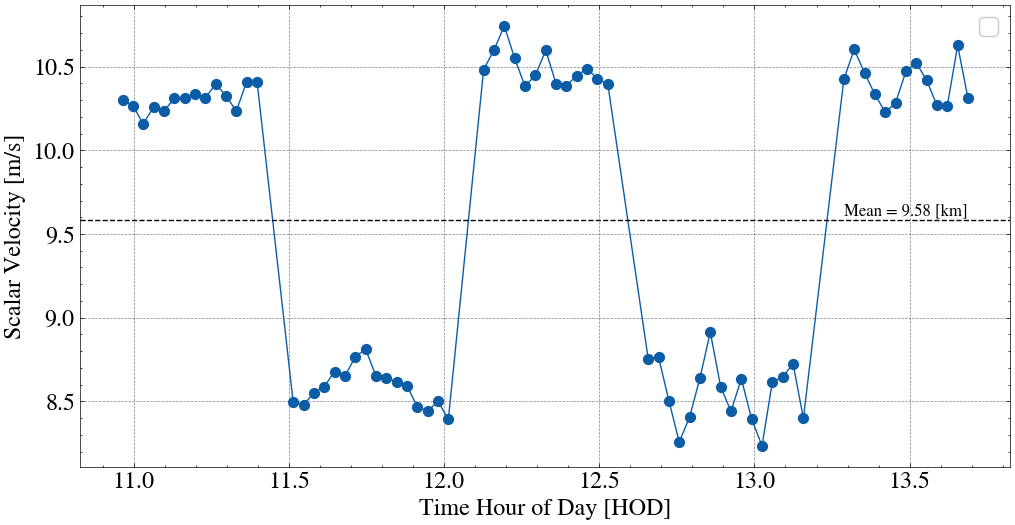

In [85]:
plt.figure(figsize=(12,6))
plt.plot(ds.SOW2HOD(DS["time"])[delta_id], Spatial_res, lw=1)
plt.scatter(ds.SOW2HOD(DS["time"])[delta_id], Spatial_res, s=50)
plt.xlabel("Time Hour of Day [HOD]")
plt.ylabel("Scalar Velocity [m/s]")
plt.legend()
plt.axhline(np.mean(Spatial_res), ls="--", lw=1, color="black")
plt.text(ds.SOW2HOD(DS["time"])[delta_id][-1], np.mean(Spatial_res), f"Mean = {np.round(np.mean(Spatial_res), 2)} [km]", fontsize=12, horizontalalignment='right', verticalalignment="bottom")
plt.show()

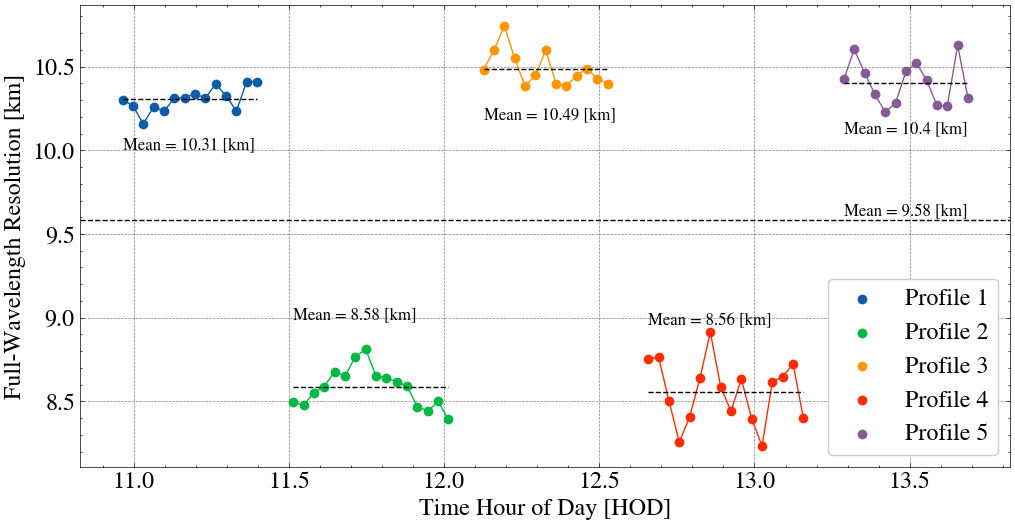

In [107]:
# Sample data (replace this with your actual data)
time_vector = DS["time"][delta_id]  # Example time vector
data = Spatial_res  # Example data corresponding to time vector

# Calculate differences in time vector to define subset boundaries
subset_indices = np.where(np.diff(time_vector) > 150)[0] + 1
subset_indices = np.insert(subset_indices, 0, 0)
subset_indices = np.append(subset_indices, len(time_vector))
plt.figure(figsize=(12,6))
# Plot each subset separately
for i in range(len(subset_indices) - 1):
    subset_data = data[subset_indices[i] : subset_indices[i+1]]
    subset_time = time_vector[subset_indices[i] : subset_indices[i+1]]
    plt.scatter(ds.SOW2HOD(subset_time), subset_data, label=f"Profile {i+1}")
    plt.plot(ds.SOW2HOD(subset_time), subset_data, lw=1)
    plt.plot([ds.SOW2HOD(subset_time)[0], ds.SOW2HOD(subset_time)[-1]], 
             [np.mean(subset_data), np.mean(subset_data)], ls="--", lw=1, color="black")
    if np.mean(subset_data) > np.mean(Spatial_res):
        plt.text(ds.SOW2HOD(subset_time)[0], np.mean(subset_data)-.3, 
                    f"Mean = {np.round(np.mean(subset_data), 2)} [km]", fontsize=12, horizontalalignment='left')
    elif np.mean(subset_data) < np.mean(Spatial_res):
        plt.text(ds.SOW2HOD(subset_time)[0], np.mean(subset_data)+.4, 
            f"Mean = {np.round(np.mean(subset_data), 2)} [km]", fontsize=12, horizontalalignment='left')
# Add labels and legend
plt.xlabel("Time Hour of Day [HOD]")
plt.ylabel('Full-Wavelength Resolution [km]')
plt.legend(loc="lower right")
plt.axhline(np.mean(Spatial_res), ls="--", lw=1, color="black")
plt.text(ds.SOW2HOD(DS["time"])[delta_id][-1], np.mean(Spatial_res), f"Mean = {np.round(np.mean(Spatial_res), 2)} [km]", fontsize=12, horizontalalignment='right', verticalalignment="bottom")

# Show the plot
plt.show()




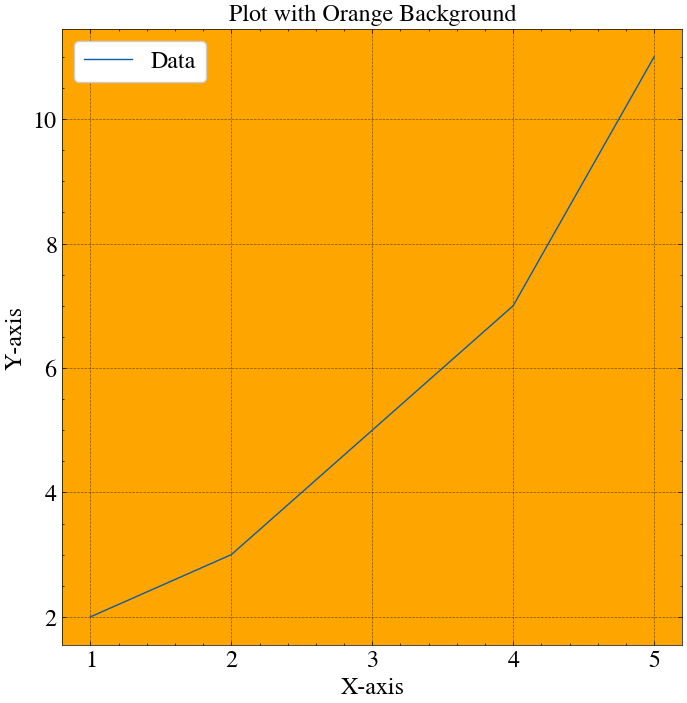

In [116]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8,8))

# Set the background color to orange
ax.set_facecolor('orange')

# Plot some data
x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]
ax.plot(x, y, label='Data')

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Plot with Orange Background')

# Add legend
ax.legend()

# Show the plot
plt.show()